**Introduction**

The goal of our project is to identify what word is spoken in an audio clip. 

In [1]:
# import libraries
import autograd.numpy as np
from autograd import hessian
from autograd import grad
from autograd. misc. flatten import flatten_func
from skimage.feature import hog
import matplotlib.pyplot as plt
import os
from autograd import value_and_grad
from scipy import signal
from scipy.io import wavfile
import itertools

Create Arrays of paths to the waveform files for speaker 1 and speaker 2

In [2]:
path = 'speaker_dataset/Speaker01'
path2 = 'speaker_dataset/Speaker02'
data = os.listdir(path)
data2 = os.listdir(path2)
paths = []
for str in data:
  paths.append(path + '/' + str)
for str in data2:
  paths.append(path2 + '/' + str)



De-Noising:
Attempt 1:
Use FFT to find dominant frequencies in the waveform. Take out the frequencies below a certain power threshold. Reconstruct the signal with only the frequencies with powers above the threshold. 

In [3]:
def denoise(samples, sample_rate):
    """
    denoise takes the fft of a sampled signals, attenuates low frequencies, and takes the inverse fft to reconstruct the signal

    :samples: the samples of the original signal
    :sample_rate: the sample rate of the signal

    :return: the filtered samples
    """
    n = len(samples)
    fhat = np.fft.fft(samples, n)
    PSD = fhat * np.conj(fhat)/n
    indices = PSD > 0.1*(10**0)
    PSDclean = PSD * indices
    fhat = indices * fhat
    ffilt = np.fft.ifft(fhat)
    
    return ffilt

In [4]:

def take_spectro(args):
  """
  take_spectro generates list of spectrograms and the returns size of the largest spectrogram

  :args: a list of paths to waveform files
  :return: s which is a list of spectrograms and minimum which is the number of columns of the largest spectrogram
  """
  s = []
  minimum = 0
  for path in args:
    sample_rate, samples = wavfile.read(path)
    samples = denoise(samples, sample_rate)
    S, F, T, Im = plt.specgram(samples, Fs = sample_rate)
    if T.size > minimum:
      minimum = T.size
    s.append(S)
  return s, minimum

In [5]:
def get_y(args):
  """
  get_y generates a list of the proper label for each spectrogram

  :args: a list of waveform files
  :return: y which is a list of the corresponding label for the waveform files
  """
  y = []
  for string in args:
    a = string[0]
    a = int(a)
    y.append(a)
  return y

In [6]:
def get_feature(spectros):
  """
  get_feature generates a list of feature vector for a list of spectrograms

  :spectros: a list of spectrograms
  :return: x which is a the list of feature vectors

  """
  x = []
  for spectro in spectros:
    freqs = spectro.shape[0]
    times = int(spectro.size/freqs)
    edges = hog(np.reshape(spectro,(freqs,times)),
        orientations = 10,
        pixels_per_cell=(21, 21),
        cells_per_block=(1, 1),
        feature_vector = True)
    x.append(edges)
  return x

In [7]:
def pad(spectros, most):
  """
  pad pads the list of spectrograms of different lengths and returns the list of padded spectrograms
  
  :spectros: a list of spectrograms
  :most: the number of columns in the largest spectrogram
  :return: new which is the new list of padded spectograms
  """
  new = []
  for spec in spectros:
    spec_freq_range = spec.shape[0]
    times = spec.shape[1]
    diff = most - times
    padding = np.zeros((spec_freq_range,diff))
    temp = np.hstack((spec,padding))
    print(temp.shape)
    new.append(temp)
  return new


In [8]:
def softmax(w,x,y):
    """
    softmax computes the softmax cost for a given set of weights, input data and proper output labels
    :w: the set of weights for the model
    :x: the set of inputs
    :y: the proper label for the input
    :return: the softmax cost for the given weights
    """
    cost = np.sum(np.log(1 + np.exp(-1*model(x,w)*y)))
    return cost/float(y.size)

In [9]:
def model(x,w):
    """ 
    model computes the given output for a weight and input
    :x: the set of inputs
    :w: the set of weights
    :return: the predicted outputs
    """
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

In [10]:
def gradient_descent(alpha,max_its,w,g,x,y, xval, yval):
    g_flat, unflatten, w = flatten_func(g, w)
    gradient = value_and_grad(g_flat)
    N = np.shape(x)[0]
    cost_hist = []
    w_hist = [unflatten(w)];
    C, G = gradient(w,x,y)

    cost_hist.append(C)

    ## ADDED for early stopping
    increase_streak = 0
    past_error, past_gradient = gradient(w, xval, yval)

    # run the gradient descent loop
    for k in range(1,max_its+1):
        # evaluate the gradient, store current weights and cost function value
        cost_eval, grad_eval = gradient(w,x,y)
        grad_eval.shape = np.shape(w)

        # take gradient descent step
        w = w - alpha*grad_eval
        cost_hist.append(cost_eval)
        w_hist.append(unflatten(w))

        ## added for early stopping
        # Note we comment out this section to make the history of validation misclassification plot show how misclassifications increase from overfitting
        #val_cost_eval, val_grad_eval = gradient(w, xval, yval)
        #if past_error > val_cost_eval:
          #increase_streak = 0
        #else:
          #increase_streak +=1
        #if increase_streak > 0:
          #break

    return w_hist, cost_hist

**Learning Process**

To train our weights, we used gradient descent along with One-vs-All classification. This means that the final output of our model is a 10x961 matrix, with rows corresponding to our potential classes and columns to the various features in our feature vector. We have our function return a (max_iterations*10 + 10)x961 matrix so that we can recover the weights for each step of optimization.


In [11]:
# for multi-class classification
def misclass(x, y, w):
  predicted = np.argmax(model(x, w), axis = 0)
  actual = y
  number = np.sum(predicted!=actual)
  return number

In [12]:
# advanced misclass for classification and frequency that each number is misclassified
def advanced_misclass(x, y, w):
    predicted = np.argmax(model(x, w), axis=0)
    actual = y
    count = 0
    misclassified_num = np.zeros(10)
    misclassified_as = np.zeros(10)
    for i in range(len(predicted)):
        if predicted[i] != actual[i]:
            count +=1
            misclassified_num[actual[i]] +=1
            misclassified_as[predicted[i]] +=1
    return count, misclassified_num, misclassified_as



In [13]:
## One Versus All classification:
# Returns the weights for each step of gradient descent to allow for history plot
def OVA(alpha,max_its,w,g,xtrain,ytrain, xval, yval):
    W = []
    for j in range(0, int(np.max(ytrain))+1):
        yj = 2 * (ytrain == j) - 1
        yj2 = 2 * (yval == j) - 1
        weights, costs = gradient_descent(alpha,max_its,w,g,xtrain,yj, xval, yj2)
        for newest_weight in weights:
          newest_weight = newest_weight/np.sqrt(np.dot(newest_weight[1:].T, newest_weight[1:])) # normalization step
          W.append(newest_weight)
    return W

In [14]:
# returns the weight for a given step in gradient descent
def weight_for_step(W, step_number):
  for i in range(0, 10):
    Wtemp = W[:, (i*500+step_number)]
    if i == 0:
      Wnew = Wtemp
    else:
      Wnew = np.vstack((Wnew, Wtemp))
  Wnew = Wnew.reshape((10, 1921)).T
  return Wnew


In [15]:
# Returns number of validation misclassifications for model at each step of gradient descent
def validation_accuracy_history(W, num_steps, xv, yv, xt, yt):
  validation_misclass = np.zeros(num_steps)
  training_misclass = np.zeros(num_steps)
  for current_step in range(num_steps):
    current_weight = weight_for_step(W, current_step)
    validation_misclass[current_step] = misclass(xv, yv, current_weight)
    training_misclass[current_step] = misclass(xt, yt, current_weight)

  return validation_misclass, training_misclass

In [16]:
def random_sample(x,y,trainp):
  len = y.size
  cutoff = len*trainp
  choice = np.random.choice(len,len,replace =False)
  train = np.array(choice < cutoff)
  val = np.array(choice >= cutoff)
  nums = np.arange(0,len)
  train = nums[train]
  val = nums[val]
  y = np.array(y)
  x = np.array(x)
  yt = np.array(y[train])
  xt = np.array(x[:,train])
  yv = np.array(y[val])
  xv = np.array(x[:,val])
  return xt, yt, xv, yv

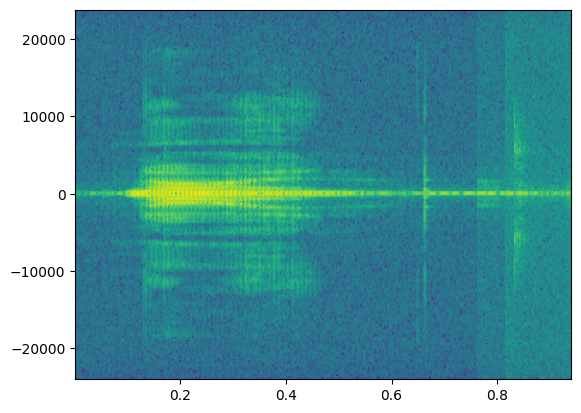

In [17]:
y = np.array(get_y(data))
y2 = np.array(get_y(data2))
y = np.append(y, y2)
# array of proper classifications
x, largest = take_spectro(paths)


In [18]:
newx = pad(x,largest)
# get them all to the same size
# with the filtering the size of the spectrograms isn't constant so the 129 is a problem

(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)
(256, 352)

In [19]:
xfinal = np.array(get_feature(newx)).T

# the feature vectors for the spectrograms

In [20]:
def standardization(x):
    mean_x = np.nanmean(x, axis=1)[:, None]
    std_x = np.nanstd(x, axis=1)[:, None]

    index = np.argwhere(std_x < 10 **(-3))
    if len(index) > 0:
        index = [i[0] for i in index]
        fix = np.zeros((std_x.shape))
        fix[index] = 1.0
        std_x += fix

    # replace nan with mean value
    index = np.argwhere(np.isnan(x) == True)
    for i in index:
        x[i[0],i[1]] = mean_x[i[0]]

    return (x-mean_x)/std_x

In [21]:
# standard normalizes the x data
xfinal = standardization(xfinal)
xt, yt, xv, yv = random_sample(xfinal, y, 0.85)
# picks the training and validation set

In [22]:
## Training the model
alpha = 0.1
its = 500
scale = 1.5
winit = scale*np.random.randn(1921,1)
W = OVA(alpha,its,winit,softmax,xt,yt, xv, yv)
W = np.array(W)
W = W.reshape((5010, 1921)).T

# Information needed for plotting below
validation_history, training_history = validation_accuracy_history(W, its, xv, yv, xt, yt)




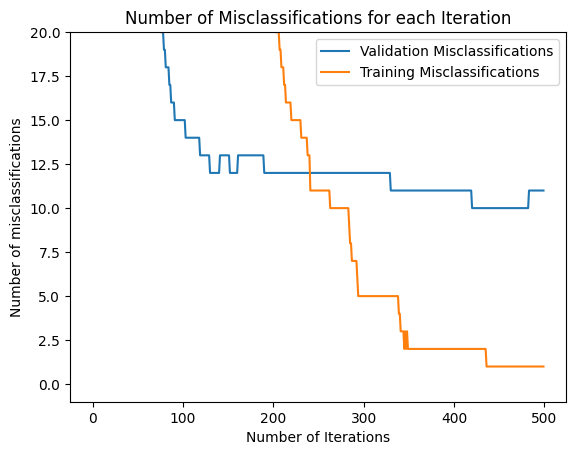

In [23]:
# Plotting training and validation misclassification history
x_axis = np.arange(500)
y_axis1 = validation_history
y_axis2 = training_history

plt.plot(x_axis, y_axis1, label='Validation Misclassifications')
plt.plot(x_axis, y_axis2, label='Training Misclassifications')
plt.xlabel("Number of Iterations")
plt.ylabel("Number of misclassifications")
plt.ylim(-1, 20)
plt.title("Number of Misclassifications for each Iteration")
plt.legend()



In [24]:
Wfinalstep = weight_for_step(W, its-1)

training_misclassifications = misclass(xt, yt, Wfinalstep)
validation_misclassifications = misclass(xv, yv, Wfinalstep)

print("Training Misclassifications: ", training_misclassifications)
training_accuracy = (yt.size - training_misclassifications)/(yt.size) * 100
print("Training Accuracy: ", training_accuracy, "%")
print("Validation Misclassifications: ", validation_misclassifications)
validation_accuracy = (yv.size - validation_misclassifications)/(yv.size) * 100
print("Validation Accuracy: ", validation_accuracy, "%")

Training Misclassifications:  1
Training Accuracy:  99.88235294117646 %
Validation Misclassifications:  11
Validation Accuracy:  92.66666666666666 %


When using FFT to filter the out the frequencies with low power, the validation accuracy improved. Cutoff of 0.1*10^-4 for PSD. Around 88% validation accuracy. Pretty darn good. Better at 0.1*10^-0. Next step is changing get_feature and seeing if a smaller feature vector can perfect linear learning, after that, start non-linear learning strategy.


**Sources**

**Dataset**: AudioMNIST from Becker et al


**Application Reference**:

"Evaluation of the efficiency of state-of-the-art Speech Recognition Engines" by Trabelsi et al
